# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_50', 'ORACLE.run2_38', 'ORACLE.run2_20', 'ORACLE.run2_26', 'ORACLE.run2_14', 'ORACLE.run2_32', 'ORACLE.run2_44', 'ORACLE.run2_8'}


{'ORACLE.run1_14', 'ORACLE.run1_38', 'ORACLE.run1_20', 'ORACLE.run1_44', 'ORACLE.run1_26', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_50'}


tensor([[[ 0.3782, -0.4778, -1.5129,  ..., -1.0750, -0.3185,  0.6370],
         [ 0.4579, -0.2190,  0.3782,  ...,  0.5574,  0.0398,  0.8958]],

        [[ 1.0162, -0.3835, -0.4218,  ..., -0.3260,  0.5752,  0.8628],
         [ 0.3643,  0.2493, -0.0959,  ..., -0.0575, -0.6136, -1.0546]],

        [[ 0.2806,  1.1037, -0.0187,  ..., -0.2432,  1.1599,  0.1310],
         [-0.9354, -0.3554, -1.4218,  ...,  1.1973, -0.3367, -1.4218]],

        ...,

        [[-0.2163, -0.6655, -0.0166,  ...,  0.2828,  0.8652,  0.5490],
         [-0.2496, -0.8984,  0.8984,  ...,  1.1147,  1.4475, -0.5324]],

        [[ 0.5835,  0.0172,  0.0343,  ..., -1.1155, -0.7551,  0.0000],
         [-1.3043, -0.0858,  0.8924,  ...,  0.7551,  0.4290, -1.0125]],

        [[ 1.3633,  0.4260, -1.0395,  ..., -0.1704, -0.2215, -0.3067],
         [ 0.6305,  1.9938,  0.3579,  ...,  0.3919, -0.3919, -0.2727]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 9.9577, train_label_loss: 2.7575, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3211.3046, train_label_loss: 1.2853, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3205.6255, train_label_loss: 0.6931, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3207.3250, train_label_loss: 1.4642, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3199.5094, train_label_loss: 0.8293, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3210.7468, train_label_loss: 0.4868, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3210.2366, train_label_loss: 0.8174, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3207.3089, train_label_loss: 1.4877, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3208.0896, train_label_loss: 1.3999, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3206.3068, train_label_loss: 0.7905, 


epoch: 1, source_val_acc_label: 0.6381, target_val_acc_label: 0.6502, source_val_label_loss: 0.9795, target_val_label_loss: 0.9459, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9631, train_label_loss: 1.3353, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3231.1013, train_label_loss: 0.6928, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3234.0986, train_label_loss: 0.7341, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3240.2359, train_label_loss: 1.3279, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3227.1321, train_label_loss: 0.4556, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3239.2878, train_label_loss: 0.7906, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3248.8991, train_label_loss: 0.8558, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3221.1930, train_label_loss: 0.8920, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3245.8968, train_label_loss: 1.4959, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3243.5802, train_label_loss: 0.4900, 


epoch: 2, source_val_acc_label: 0.6627, target_val_acc_label: 0.6710, source_val_label_loss: 0.8998, target_val_label_loss: 0.8669, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.9698, train_label_loss: 0.4173, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3233.5995, train_label_loss: 0.9274, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3240.9680, train_label_loss: 1.3473, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3226.8821, train_label_loss: 0.4772, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3230.1020, train_label_loss: 0.8237, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3246.7577, train_label_loss: 0.7215, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3242.3314, train_label_loss: 0.5102, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3231.8471, train_label_loss: 1.0796, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3237.7467, train_label_loss: 0.5731, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3239.4873, train_label_loss: 1.1813, 


epoch: 3, source_val_acc_label: 0.6905, target_val_acc_label: 0.7005, source_val_label_loss: 0.8309, target_val_label_loss: 0.8009, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.9672, train_label_loss: 0.9893, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3234.3702, train_label_loss: 0.5537, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3234.6698, train_label_loss: 1.1041, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3234.4702, train_label_loss: 0.9088, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3225.6441, train_label_loss: 0.5191, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3243.6665, train_label_loss: 0.6037, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3248.6514, train_label_loss: 0.7015, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3229.0300, train_label_loss: 1.0392, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3233.7329, train_label_loss: 0.3009, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3216.7478, train_label_loss: 0.8391, 


epoch: 4, source_val_acc_label: 0.7148, target_val_acc_label: 0.7197, source_val_label_loss: 0.7861, target_val_label_loss: 0.7591, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.9690, train_label_loss: 0.8809, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3227.6514, train_label_loss: 0.4496, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3235.5921, train_label_loss: 0.7595, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3239.4629, train_label_loss: 0.6538, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3229.4723, train_label_loss: 0.4815, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3240.2788, train_label_loss: 1.0133, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3244.4167, train_label_loss: 0.5097, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3233.7469, train_label_loss: 0.8784, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3238.8857, train_label_loss: 0.5217, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3244.6740, train_label_loss: 0.7075, 


epoch: 5, source_val_acc_label: 0.7209, target_val_acc_label: 0.7239, source_val_label_loss: 0.7703, target_val_label_loss: 0.7458, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9685, train_label_loss: 0.2558, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3228.7640, train_label_loss: 0.9668, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3241.5522, train_label_loss: 0.5599, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3231.0025, train_label_loss: 0.6253, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3231.7424, train_label_loss: 0.4484, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3245.7775, train_label_loss: 0.3975, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3238.4064, train_label_loss: 1.0212, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3231.9620, train_label_loss: 0.5447, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3238.1356, train_label_loss: 0.5131, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3239.9869, train_label_loss: 0.4526, 


epoch: 6, source_val_acc_label: 0.7275, target_val_acc_label: 0.7294, source_val_label_loss: 0.7549, target_val_label_loss: 0.7338, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9658, train_label_loss: 0.2627, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3233.2145, train_label_loss: 0.4170, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3227.9101, train_label_loss: 0.4446, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3224.7349, train_label_loss: 0.8189, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3233.5969, train_label_loss: 0.8152, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3242.0738, train_label_loss: 0.2945, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3234.6083, train_label_loss: 0.5583, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3232.5993, train_label_loss: 0.6134, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3237.4679, train_label_loss: 0.6462, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3242.8947, train_label_loss: 0.4414, 


epoch: 7, source_val_acc_label: 0.7327, target_val_acc_label: 0.7358, source_val_label_loss: 0.7713, target_val_label_loss: 0.7517, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.9683, train_label_loss: 0.4658, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3229.8007, train_label_loss: 0.3488, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3221.9145, train_label_loss: 0.3999, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3226.1475, train_label_loss: 0.3660, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3229.1259, train_label_loss: 0.3411, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3244.9068, train_label_loss: 0.6642, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3240.1925, train_label_loss: 0.3238, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3230.5507, train_label_loss: 0.3354, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3235.9473, train_label_loss: 0.7904, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3249.4168, train_label_loss: 0.2217, 


epoch: 8, source_val_acc_label: 0.7343, target_val_acc_label: 0.7353, source_val_label_loss: 0.7624, target_val_label_loss: 0.7469, 


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.9657, train_label_loss: 0.3356, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3232.1646, train_label_loss: 0.5513, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3229.8834, train_label_loss: 0.4645, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3236.8477, train_label_loss: 0.3164, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3227.9573, train_label_loss: 0.4863, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3232.7867, train_label_loss: 0.3021, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3241.0867, train_label_loss: 0.1037, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3221.6877, train_label_loss: 0.3945, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3236.3828, train_label_loss: 0.7504, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3238.9136, train_label_loss: 0.4585, 


epoch: 9, source_val_acc_label: 0.7352, target_val_acc_label: 0.7351, source_val_label_loss: 0.7792, target_val_label_loss: 0.7685, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.9657, train_label_loss: 0.3649, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3233.0701, train_label_loss: 0.1845, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3231.2199, train_label_loss: 0.4482, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3228.0343, train_label_loss: 0.5199, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3230.0472, train_label_loss: 0.1897, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3231.1172, train_label_loss: 0.1546, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3242.7192, train_label_loss: 0.2944, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3231.6478, train_label_loss: 0.2497, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3243.3964, train_label_loss: 0.2459, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3248.9053, train_label_loss: 0.3320, 


epoch: 10, source_val_acc_label: 0.7331, target_val_acc_label: 0.7309, source_val_label_loss: 0.7991, target_val_label_loss: 0.7863, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9621, train_label_loss: 0.3931, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3228.6614, train_label_loss: 0.4744, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3236.9373, train_label_loss: 0.3887, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3234.6479, train_label_loss: 0.3488, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3227.2170, train_label_loss: 0.3539, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3237.6723, train_label_loss: 0.1875, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3237.2022, train_label_loss: 0.3376, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3230.9298, train_label_loss: 0.4085, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3246.5918, train_label_loss: 0.2351, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3241.4290, train_label_loss: 0.5033, 


epoch: 11, source_val_acc_label: 0.7307, target_val_acc_label: 0.7285, source_val_label_loss: 0.8114, target_val_label_loss: 0.8082, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

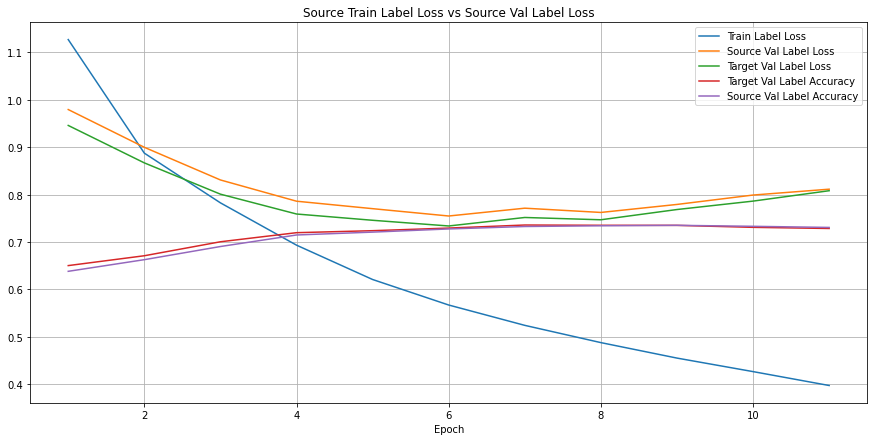

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

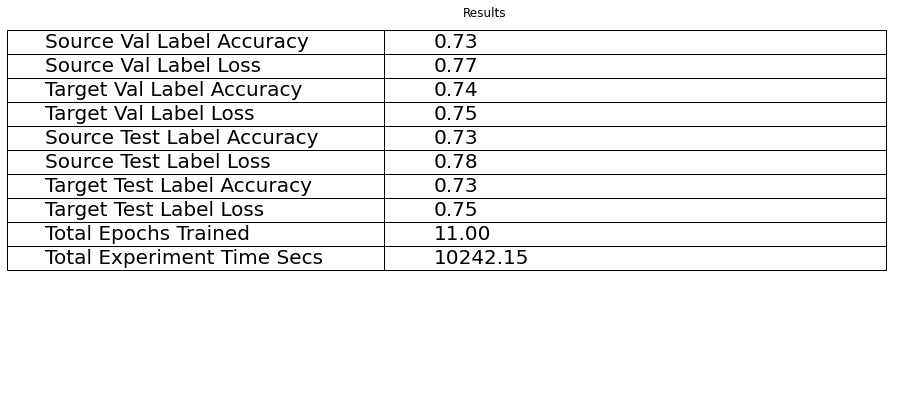

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

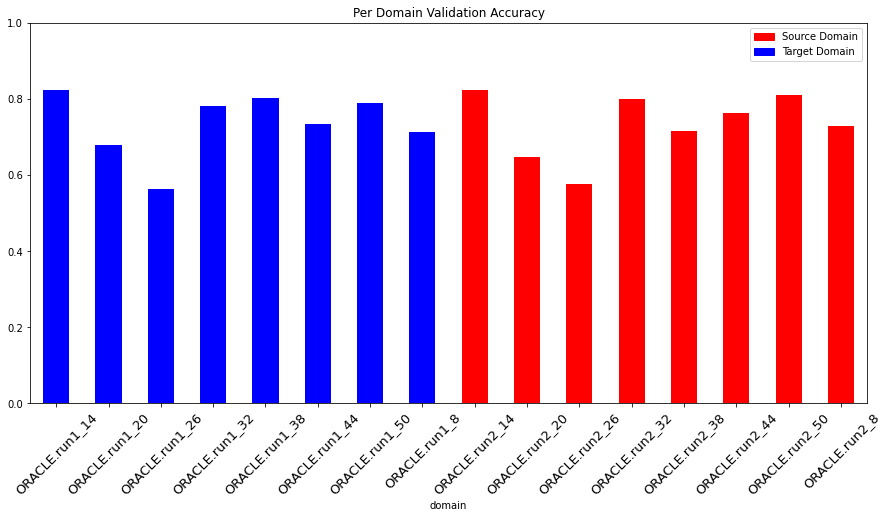

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.73095703125 Target Test Label Accuracy: 0.7348763020833333
Source Val Label Accuracy: 0.7326888020833333 Target Val Label Accuracy: 0.7358463541666667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"